In [1]:
# import required modules
import numpy as np
import sys    
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly
plotly.tools.set_credentials_file(username='adityadesai', api_key='OhKTNzY8ebJVtqeQhogI')

# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [3]:
# reading dataset and storing the data points
fo = open("./genomedata.csv", "r")
points = []
sequences = []
sequence = ""
for line in fo:
    
    #print((line))
    if(line[0] == '>'):
        dataPoint = (line[1:]).replace('\n','').replace('chr','')
        if(dataPoint is not ''):
            points.append(dataPoint)
        if(sequence is not ''):
            sequences.append(sequence)
        sequence = ""
    else:
        sequence = sequence + line.replace('\n','')
    

In [4]:
# created a mapping from point names to point_i and point_i to sequence values
sequencesDictionary = {}
pointsDictionary = {} 
for i in range(len(points)):
    sequencesDictionary["point_" + str(i)] = sequences[i]
    pointsDictionary[points[i]] = "point_" + str(i)

In [5]:
# function to calculate distance between two points
# this is basically the global sequence alignment score 

def calculatePointsDistance(sequencesDictionary,point1,point2):
    # rules 
    gap = -2
    match = 1
    mismatch = -1
    
    # getting the sequences
    sequence1 = " " + sequencesDictionary[point1]
    sequence2 = " " + sequencesDictionary[point2]

    #print(len(sequence1))
    #print(len(sequence2))
    
    
    # 2D numpy array of dimensions (len(sequence1) + 1) by (len(sequence2) + 1)
    GSAM = np.zeros(((len(sequence1)),(len(sequence2))))
    
    # initializing the boundary
    for i in range(1,(len(sequence1))):
        GSAM[i][0] = GSAM[i-1][0] + gap
    for j in range(1,(len(sequence2))):
        GSAM[0][j] = GSAM[0][j-1] + gap
    
    
    # calculating the element score value
    for i in range(1,(len(sequence1))):
        for j in range(1,(len(sequence2))):
            topChange = GSAM[i-1][j] + gap
            leftChange = GSAM[i][j -1] + gap
            if(sequence1[i] == sequence2[j]):
                diagonalChange = GSAM[i-1][j -1] + match
            else:
                diagonalChange = GSAM[i-1][j -1] + mismatch
            
            
            GSAM[i][j]  = np.max([topChange,leftChange,diagonalChange])

    
    return GSAM[len(sequence1)-1][len(sequence2)-1]
    
    
calculatePointsDistance(sequencesDictionary,"point_8","point_28")

-2185.0

In [12]:
fo = open("./pointsDistanceMatrix.csv","r")
pointsDistanceMatrix = np.zeros((len(points),len(points)))
counter = 0
for line in fo:
    splitlist = ((line.split(",")))
    for j in range(len(splitlist)):
        pointsDistanceMatrix[counter][j] = int(splitlist[j])
    counter+=1

In [13]:
# function to calculate the distance between two clusters
def calculateClustersDistance(pointsDistanceMatrix,cluster1,cluster2):
    # average linkage
    
    sumClusterInternalDistances = 0
    counter = 0
    for item1 in cluster1:
        for item2 in cluster2:
            #print(item1,item2)
            sumClusterInternalDistances += pointsDistanceMatrix[int(item1.replace('point_',''))][int(item2.replace('point_',''))]
            counter+=1
            
    return sumClusterInternalDistances/counter 

#calculateClustersDistance(pointsDistanceMatrix,['point_1'],['point_2'])

In [14]:
# making the cluster distance matrix
clusterDistanceMatrix = np.zeros((2*len(points)-1,2*len(points)-1))
for i in range(len(clusterDistanceMatrix)):
    for j in range(len(clusterDistanceMatrix)):
        if i < len(points) and j < len(points):
            clusterDistanceMatrix[i][j] = pointsDistanceMatrix[i][j]
        else:
                clusterDistanceMatrix[i][j]= -sys.maxsize

# this is to say that the the distance between a cluster and itself is as minimum as possible it
for i in range(len(clusterDistanceMatrix)):
    clusterDistanceMatrix[i][i]= -sys.maxsize

# function to reduce the clusters to the required number of clusters
# n is the required number of clusters

def clustering(clusterDistanceMatrix, n,numpoints):
    counter = 0
    removedIndices = []
    indexToListMap ={}
    for i in range(numpoints):
        indexToListMap[i]=["point_"+str(i)]
    totalNumClusters = numpoints
    
    Z = [] # from scipy see linkage clustering
    
    #print(indexToListMap)
    while(totalNumClusters>n):
            # getting the indices of max element
            
            (row, col) = np.unravel_index(np.argmax(clusterDistanceMatrix, axis=None), clusterDistanceMatrix.shape)
            high=col
            low=row

            if(row>col):
                low=col
                high=row
            
            #print(low,high)
            
            indexToListMap[counter+numpoints] = indexToListMap[low] + indexToListMap[high]            
            indexToListMap.pop(high,None)
            indexToListMap.pop(low,None)
            removedIndices.append(high)
            removedIndices.append(low)
            
            
            Z.append([low,high,500-np.max(clusterDistanceMatrix),len(indexToListMap[counter+numpoints])])
                        
            #print(removedIndices)
            # make the high & low - rows and cols min so that they don't interfere later on
            for i in range(clusterDistanceMatrix.shape[0]):
                clusterDistanceMatrix[high][i] = -sys.maxsize
                clusterDistanceMatrix[i][high] = -sys.maxsize
                clusterDistanceMatrix[i][low] = -sys.maxsize
                clusterDistanceMatrix[low][i] = -sys.maxsize
                
            # calculate the cluster distance between cluster at low and i and update the row and col at index low 
            for i in range(counter+numpoints):
                if i not in removedIndices:
                    dist = calculateClustersDistance(pointsDistanceMatrix,indexToListMap[i],indexToListMap[counter+numpoints])
                    clusterDistanceMatrix[counter+numpoints][i]=dist
                    clusterDistanceMatrix[i][counter+numpoints]=dist

            totalNumClusters=totalNumClusters-1
            counter+=1

    
    return indexToListMap , Z
    
    


In [15]:
clusters,Z = clustering(clusterDistanceMatrix,1,len(points))
print(len(clusters.keys()))
print(clusters.keys())
#clusters

1
dict_keys([620])


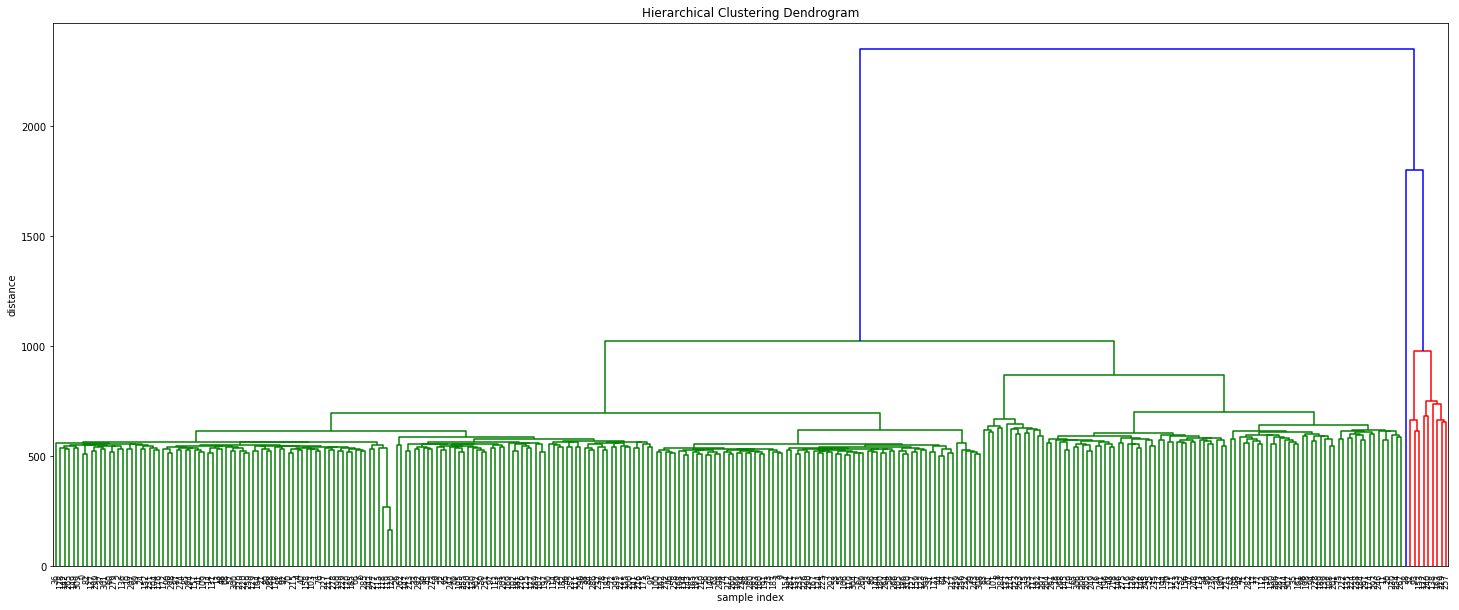

In [16]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()